In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as custom_tfms
import seaborn as sns

torch.cuda.set_device(0) 


def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df

In [2]:
X = np.load('./data/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
label_df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(label_df)


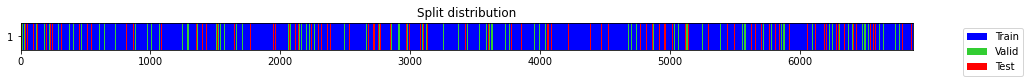

((#5503) [3730,369,1166,1104,1256,1925,1397,6851,5431,5658...],
 (#687) [3536,5567,3053,1591,268,2755,6308,2063,3139,3885...],
 (#687) [4921,3129,4389,2920,319,6726,55,1263,3608,2788...])

In [3]:
splits = get_splits(y.to_numpy(), valid_size=.1,test_size=0.1, stratify=True, random_state=23, shuffle=True)
splits

In [4]:
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


# Study 1

In [ ]:
# def objective(trial:optuna.Trial):
    
#     # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
#     nf = trial.suggest_int('num_filters', 16, 48, step=8) # search through all categorical values in the provided list
#     depth = trial.suggest_int('depth', 3, 9, step=3) # search through all integer values between 3 and 9 with 3 increment steps
#     dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
#     batch_tfms = TSStandardize(by_sample=True)
#     tfms  = [None, TSMultiLabelClassification()]
#     batch_tfms = [TSStandardize(by_sample=True)]
#     dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
#     dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
#     metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 

#     model = InceptionTimePlus(dls.vars, dls.c, dls.len,nf=nf, fc_dropout=dropout_rate, depth=depth)
#     learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


# #     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
#     learn.fit_one_cycle(100, lr_max=learning_rate)

#     # Return the objective value
#     return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

# study_name = "inception" # Unique identifier of the study.
# storage_name = "sqlite:///{}.db".format(study_name)
# study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=50),sampler=optuna.samplers.RandomSampler())

# study.optimize(objective, n_trials=100)

In [ ]:
# import optuna
# import pandas as pd
# import numpy as np
# import imp  
# study = optuna.load_study(study_name='inception', storage='sqlite:///inception.db')
# display(optuna.visualization.plot_optimization_history(study))
# display(optuna.visualization.plot_param_importances(study))
# display(optuna.visualization.plot_slice(study))
# display(optuna.visualization.plot_parallel_coordinate(study))

# study 2

In [ ]:
# def save_callback(study, trial):
#     if study.best_trial == trial:
#         PATH = Path('./models/inception_multilabel_big.pkl')
#         PATH.parent.mkdir(parents=True, exist_ok=True)
#         global learn
#         learn.export(PATH)
# def objective(trial:optuna.Trial):    
#     # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
# #     nf = trial.suggest_int('num_filters', 16, 48, step=8) # search through all categorical values in the provided list
#     depth = trial.suggest_int('depth', 12,18,step=1) # search through all integer values between 3 and 9 with 3 increment steps
#     conv_dropout = trial.suggest_float("conv_dropout", 0.0, 0.05, step=.025) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
#     learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
#     batch_tfms = TSStandardize(by_sample=True)
#     tfms  = [None, TSMultiLabelClassification()]
#     batch_tfms = [TSStandardize(by_sample=True)]
#     dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
#     dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
#     metrics = [accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 

#     model = InceptionTimePlus(dls.vars, dls.c, dls.len,conv_dropout=conv_dropout, depth=depth)
#     global learn
#     learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


# #     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
#     learn.fit_one_cycle(150, lr_max=learning_rate)

#     # Return the objective value
#     return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

# study_name = "inception_study2" # Unique identifier of the study.
# storage_name = "sqlite:///{}.db".format(study_name)
# study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=75),sampler=optuna.samplers.TPESampler())

# study.optimize(objective, n_trials=100,callbacks=[save_callback])

In [ ]:
def save_callback(study, trial):
    if study.best_trial == trial:
        PATH = Path('./models/inception_multilabel.pkl')
        PATH.parent.mkdir(parents=True, exist_ok=True)
        global learn
        learn.export(PATH)
def objective(trial:optuna.Trial):    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
#     
    tfms = []
    random_shift = trial.suggest_float('rand_shift', 0.0, 0.5, step=.05) 
    noise = trial.suggest_float("noise", 0.0, 1.5, step=.1) 
    window_slice = trial.suggest_float("window_slice", 0.0, 0.8, step=.05) 
    rescale = trial.suggest_float("scale", 0.2, 0.8, step=.1) 
    norm = trial.suggest_categorical('normalize', [0, 1]) 
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True) 
    depth = trial.suggest_int('depth', 8,14,step=1) # search through all integer values between 3 and 9 with 3 increment steps
    conv_dropout = trial.suggest_float("conv_dropout", 0.0, 0.05, step=.025) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    fc_dropout = trial.suggest_float("fc_dropout", 0.0, 0.05, step=.025) # search through all float values between 0.0 and 0.5 with 0.1 increment steps

    nf = trial.suggest_int('num_filters', 24, 36, step=4) # search through all categorical values in the provided list
    
    Xtfms = [[TSRandomShift(magnitude=random_shift),TSMagMulNoise(noise),TSWindowSlicing(magnitude=window_slice),custom_tfms.Resample(scale_factor=rescale)],TSMultiLabelClassification()]
    if norm!=0:
        Xtfms.append(custom_tfms.Normalize())
    
#     tfms  = [None, TSMultiLabelClassification()]
    batch_tfms = [TSStandardize(by_sample=True)]
    dsets = TSDatasets(X.astype(float), y_multi, tfms=Xtfms, splits=splits) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[ precision_multi, recall_multi, specificity_multi, F1_multi] 

    model = InceptionTimePlus(dls.vars, dls.c, dls.len, conv_dropout=conv_dropout, depth=depth,fc_dropout = fc_dropout,nf = nf)
    global learn
    learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


#     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
    learn.fit_one_cycle(100, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

study_name = "inception_study3" # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
                            pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(n_warmup_steps=25),patience=20),sampler=optuna.samplers.RandomSampler())

study.optimize(objective, n_trials=100,callbacks=[save_callback])

In [ ]:


tfms = [[TSRandomShift(magnitude=0.2),TSMagMulNoise(),custom_tfms.TSNormalize(),TSWindowSlicing(magnitude=0.2)],TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[32, 128], batch_tfms=batch_tfms, num_workers=0) 
# reorganize y dataframe using dl's label/vocab mapping and count pos_weights
y = y[dls.vocab.o2i.keys()]
pos_weight = (len(y)-y.sum())/(y.sum()+1e-5)
metrics =[ precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13,)
learn = Learner(dls, model, metrics=metrics, loss_func=nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight)),cbs=ShowGraph())
learn.fit_one_cycle(200, lr_max=0.004178080960048705)
learn.recorder.plot_metrics()

In [8]:
# PATH = Path('./models/inception_multilabel_bestparam.pkl')
# PATH.parent.mkdir(parents=True, exist_ok=True)
# learn.export(PATH)

In [6]:
PATH = Path('./models/inception_multilabel.pkl')
learn = load_learner(PATH, cpu=False)


In [9]:
# Xtfms = [[TSRandomShift(magnitude=best_params["rand_shift"]),TSMagMulNoise(best_params["noise"]),TSWindowSlicing(magnitude=best_params["window_slice"]),custom_tfms.Resample(scale_factor=best_params["scale"])],TSMultiLabelClassification()]
# if best_params["normalize"]!=0:
#     Xtfms[0] = Xtfms[0].append(custom_tfms.Normalize())

Xtfms = [None,TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]

dsets = TSDatasets(X.astype(float), y_multi, tfms=Xtfms, splits=(splits[0],splits[2])) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

y_pred=(valid_preds>0)
y_test=valid_targets

print(classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys()))

                              precision    recall  f1-score   support

         1st degree av block       0.85      0.90      0.87        73
         atrial fibrillation       0.93      0.91      0.92       122
    left bundle branch block       0.96      0.96      0.96        24
premature atrial contraction       0.56      0.33      0.42        60
   right bundle branch block       0.94      0.91      0.93       185
                sinus rhythm       0.69      0.66      0.68        92
               st depression       0.85      0.84      0.84        87
                st elevation       0.40      0.20      0.27        20
        ventricular ectopics       0.75      0.63      0.69        71

                   micro avg       0.84      0.78      0.81       734
                   macro avg       0.77      0.71      0.73       734
                weighted avg       0.82      0.78      0.80       734
                 samples avg       0.76      0.77      0.76       734



In [44]:
from scipy.interpolate import CubicSpline
class Scale(Transform):
    "Clip  batch of type `TSTensor`"
    parameters, order = L('min', 'max'), 90
    def __init__(self, min=-6, max=6, **kwargs):
        super().__init__(**kwargs)
        self.min = torch.tensor(min)
        self.max = torch.tensor(max)

    def encodes(self, o:TSTensor):
        output = F.interpolate(o,None,0.5)
        return output
    def __repr__(self): return f'{self.__class__.__name__}(min={self.min}, max={self.max})'
class Normalize(Transform):
    # normalize by dividing each sample by its max value
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        output = o.clone()
        for i in range(len(o)):
            output[i] = output[i]/output[i].max()
        return output
class MulNoise(Transform):
    "Applies multiplicative noise on the y-axis for each step of a `TSTensor` batch"
    order = 90
    def __init__(self, magnitude=1, ex=None, **kwargs):
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        noise = torch.normal(1, self.magnitude * .025, o.shape, dtype=o.dtype, device=o.device)
        output = o * noise
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output
class RandomShift(Transform):
    "Shifts and splits a sequence"
    order = 90
    def __init__(self, magnitude=0.02, ex=None, **kwargs):
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        pos = int(round(np.random.randint(0, o.shape[-1]) * self.magnitude)) * (random.randint(0, 1)*2-1)
        output = torch.cat((o[..., pos:], o[..., :pos]), dim=-1)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output
class WindowWarping(Transform):
    """Applies window slicing to the x-axis of a `TSTensor` batch based on a random linear curve based on
    https://halshs.archives-ouvertes.fr/halshs-01357973/document"""
    order = 90
    def __init__(self, magnitude=0.1, ex=None, **kwargs):
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0 or self.magnitude >= 1: return o
        f = CubicSpline(np.arange(o.shape[-1]), o.cpu(), axis=-1)
        output = o.new(f(random_cum_linear_generator(o, magnitude=self.magnitude)))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output
class WindowSlicing(Transform):
    "Randomly extracts an resize a ts slice based on https://halshs.archives-ouvertes.fr/halshs-01357973/document"
    order = 90
    def __init__(self, magnitude=0.1, ex=None, mode='linear', **kwargs):
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0 or self.magnitude >= 1: return o
        seq_len = o.shape[-1]
        win_len = int(round(seq_len * (1 - self.magnitude)))
        if win_len == seq_len: return o
        start = np.random.randint(0, seq_len - win_len)
        return F.interpolate(o[..., start : start + win_len], size=seq_len, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)



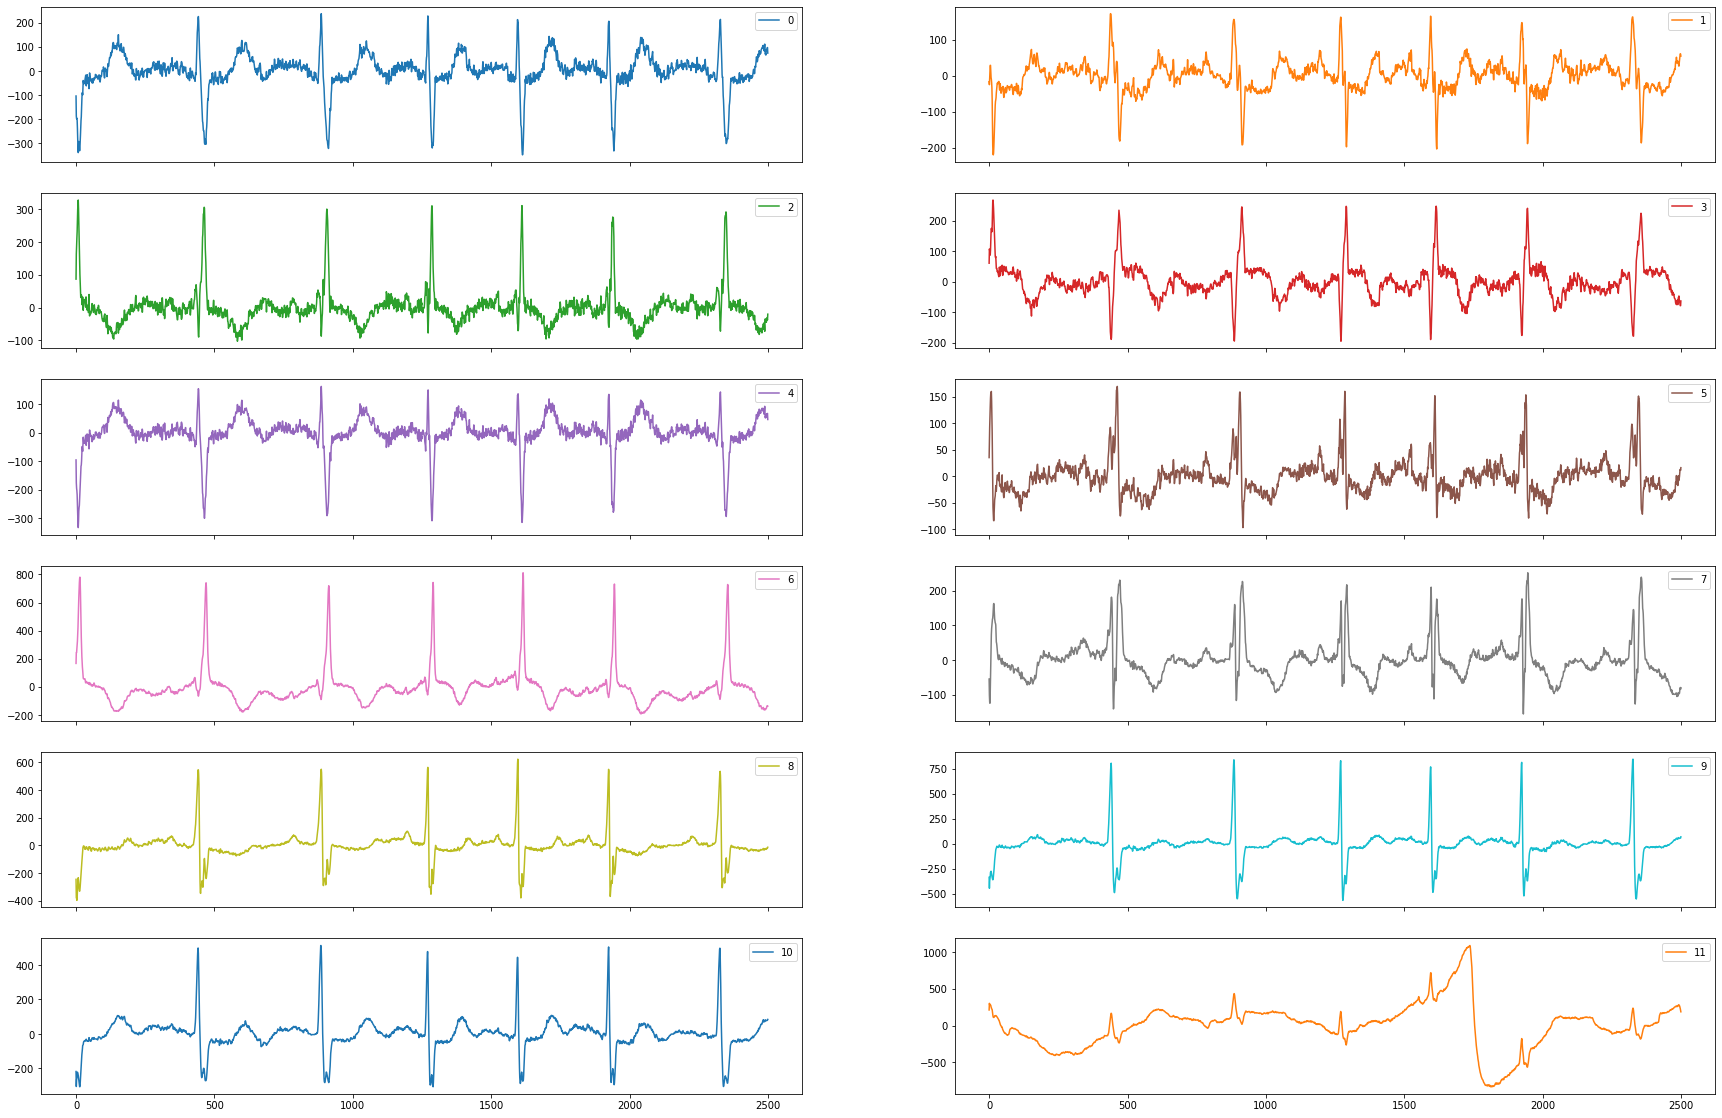

In [49]:
import transformation_funcs as custom_tfms


tfms  = [None,TSMultiLabelClassification()]
# batch_tfms = [TSRandomShift(magnitude=best_params["rand_shift"]),TSMagMulNoise(best_params["noise"]),TSWindowSlicing(magnitude=best_params["window_slice"]),custom_tfms.Resample(scale_factor=best_params["scale"]),TSStandardize(by_sample=True)]

viable_tfms = [TSNormalize(by_sample=True),TSStandardize(by_sample=True)]
batch_tfms = [WindowWarping(0.5)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)

leads = next(iter(dls.valid))[0][2]
leads = np.array(leads.cpu())
fig = pd.DataFrame(leads).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

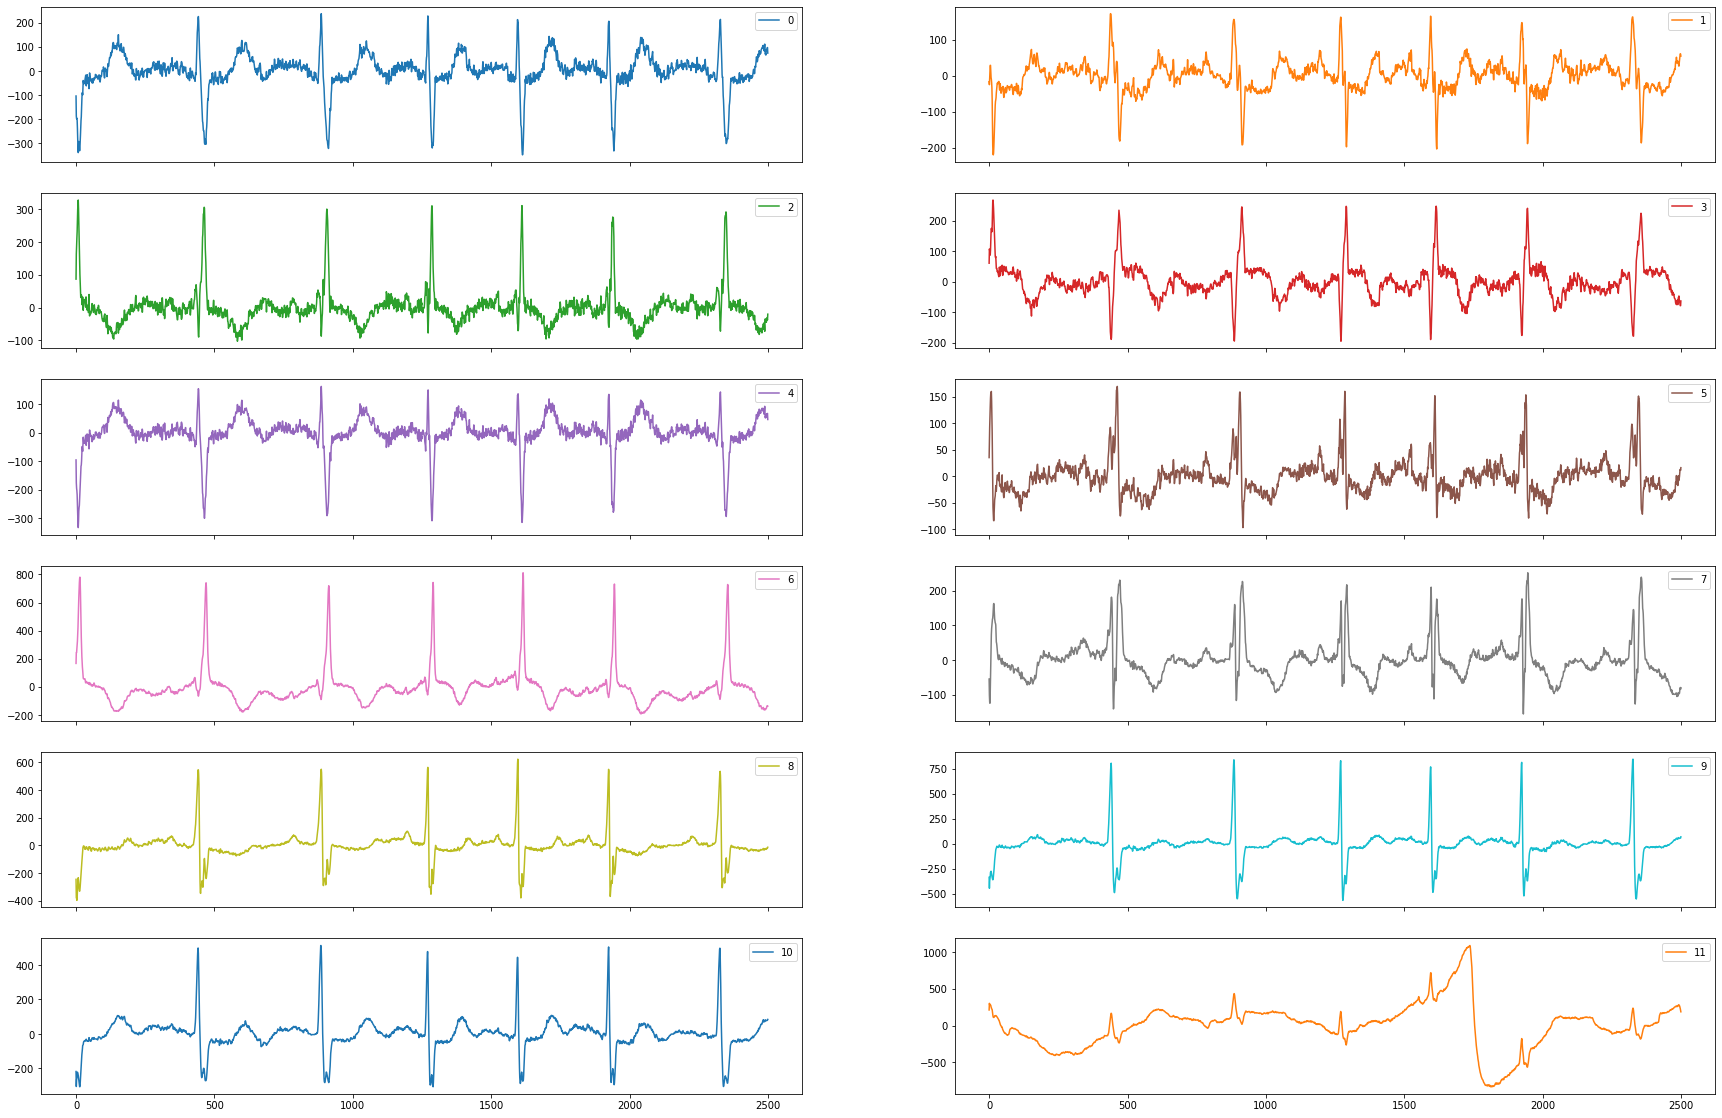

In [50]:
import transformation_funcs as custom_tfms


tfms  = [None,TSMultiLabelClassification()]
# batch_tfms = [TSRandomShift(magnitude=best_params["rand_shift"]),TSMagMulNoise(best_params["noise"]),TSWindowSlicing(magnitude=best_params["window_slice"]),custom_tfms.Resample(scale_factor=best_params["scale"]),TSStandardize(by_sample=True)]

viable_tfms = [TSNormalize(by_sample=True),TSStandardize(by_sample=True)]
batch_tfms = [WindowWarping(0.2)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)

leads2 = next(iter(dls.valid))[0][2]
leads2 = np.array(leads2.cpu())
fig = pd.DataFrame(leads).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

In [ ]:
leads1-leads2

In [ ]:
classification_report(y_test, y_pred,target_names = df.columns)

In [77]:
winner = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.795,0.897,0.865,0.821,0.911,0.734,0.852,0.788,0.509]))
winner_ensemble = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.808,0.933,0.875,0.884,0.910,0.826,0.869,0.811,0.624]))
inception = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.93,0.69,0.92,0.96,0.27,0.87,0.42, 0.68,0.84]))
inception_augmented= dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.93,0.69,0.92,0.96,0.27,0.87,0.42, 0.68,0.84]))

to_beat = dict(sorted(to_beat.items()))
best = dict(sorted(best.items()))
augmented_best = dict(sorted(augmented_best.items()))
df = pd.DataFrame([winner,winner_ensemble,inception,inception_augmented],index=["winner","winner_ensemble","inception","inception_augmented"]).T

In [86]:
df["better"] = df["winner_ensemble"]<df["inception_augmented"]
df

,winner,winner_ensemble,inception,inception_augmented,better
normal,0.795,0.808,0.48,0.68,False
AF,0.897,0.933,0.95,0.92,False
I-AVB,0.865,0.875,0.66,0.87,False
LBBB,0.821,0.884,0.50,0.96,True
RBBB,0.911,0.910,0.86,0.93,True
PAC,0.734,0.826,0.75,0.42,False
PVC,0.852,0.869,0.87,0.69,False
STD,0.788,0.811,0.64,0.84,True
STE,0.509,0.624,0.87,0.27,False
